In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In [2]:
# The Model
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

# Conv Layer 1
x = Conv2D(64, (3,3), padding = 'same')(input_img)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
# Conv Layer 2
x = Conv2D(32, (3,3), padding = 'same')(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2,2)) (x)
# Conv Layer 1
x = Conv2D(64, (3,3), padding = 'same')(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = Conv2D(64, (3,3), padding = 'same')(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2,2)) (x)

# Conv Layer 1
x = Conv2D(32, (3,3), padding = 'same')(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = Conv2D(32, (3,3), padding = 'same')(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2,2)) (x)


# Dense
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation = 'relu')(x)
outputs = Dense(2, activation='softmax')(x)




cnn_classifier = Model(input_img, outputs)
#adam = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.8, nesterov=True)
cnn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
cnn_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
__________

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!ls "/content/gdrive/My Drive/Chexnet"


image_data.npy	Untitled0.ipynb  VAE_CHEXNET.ipynb
train_v2.csv	Untitled.ipynb


In [6]:
data = np.load('/content/gdrive/My Drive/Chexnet/image_data.npy')
print(data.shape)

(26684, 4096)


In [0]:
#df = pd.read_csv('train_v2.csv')

In [0]:
x_train = data[:15000,:]
x_validation = data[15000:,:]

In [9]:
print(x_train.shape)
print(x_validation.shape)

(15000, 4096)
(11684, 4096)


In [0]:
x_train = x_train.astype('float32') / 255.
x_validation = x_validation.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))  # adapt this if using `channels_first` image data format
x_validation = np.reshape(x_validation, (len(x_validation), 64, 64, 1))  # adapt this if using `channels_first` image data format

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# Data Generator Module
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

datagen.fit(x_train)

In [0]:
import keras.utils
df = pd.read_csv('/content/gdrive/My Drive/Chexnet/train_v2.csv')
labels_train = df['Target'][:15000]
labels_test = df['Target'][15000:]
labels_train = keras.utils.to_categorical(labels_train)
labels_test = keras.utils.to_categorical(labels_test)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(monitor='loss',factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [lr_scheduler, lr_reducer]

In [14]:
from keras.callbacks import TensorBoard
epochs = 200
batch_size = 128
cnn_classifier_train = cnn_classifier.fit_generator(datagen.flow(x_train, labels_train, batch_size = 128),
                epochs=epochs,steps_per_epoch=len(x_train) / 128,
                shuffle=True,verbose = 1,
                validation_data=(x_validation, labels_test), callbacks = callbacks)


Instructions for updating:
Use tf.cast instead.
Epoch 1/200
Learning rate:  0.001
118/117 [==============================] - 19s 165ms/step - loss: 0.5761 - acc: 0.7708 - val_loss: 0.6664 - val_acc: 0.7655
Epoch 2/200
Learning rate:  0.001
118/117 [==============================] - 15s 127ms/step - loss: 0.4777 - acc: 0.7862 - val_loss: 0.9317 - val_acc: 0.2349
Epoch 3/200
Learning rate:  0.001
118/117 [==============================] - 15s 127ms/step - loss: 0.4548 - acc: 0.7946 - val_loss: 0.9474 - val_acc: 0.2345
Epoch 4/200
Learning rate:  0.001
118/117 [==============================] - 15s 126ms/step - loss: 0.4415 - acc: 0.7973 - val_loss: 0.8777 - val_acc: 0.2345
Epoch 5/200
Learning rate:  0.001
118/117 [==============================] - 15s 126ms/step - loss: 0.4376 - acc: 0.8036 - val_loss: 0.8516 - val_acc: 0.2345
Epoch 6/200
Learning rate:  0.001
118/117 [==============================] - 15s 124ms/step - loss: 0.4329 - acc: 0.8058 - val_loss: 0.5242 - val_acc: 0.7656
Epoc

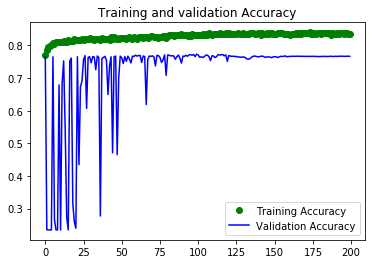

In [15]:
acc = cnn_classifier_train.history['acc']
val_acc = cnn_classifier_train.history['val_acc']
epochs = range(200)
plt.figure()
plt.plot(epochs, acc, 'go --', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

In [0]:
from keras.models import load_model
cnn_classifier.save('/content/gdrive/My Drive/Chexnet/my_model.h5')

In [0]:
from sklearn.metrics import confusion_matrix
Y_prediction = cnn_classifier.predict(x_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(labels_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

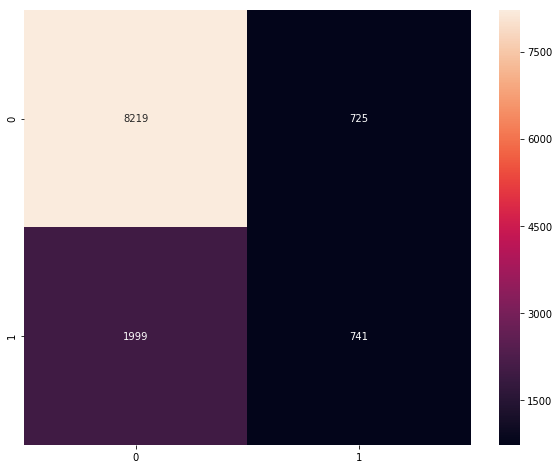

In [23]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");